#Bài tập
1. Train lại model trên bằng toàn bộ dataset hiện có.
2. Hãy train model VGG-C, và VGG-E và so sánh các kết quả trên tập test

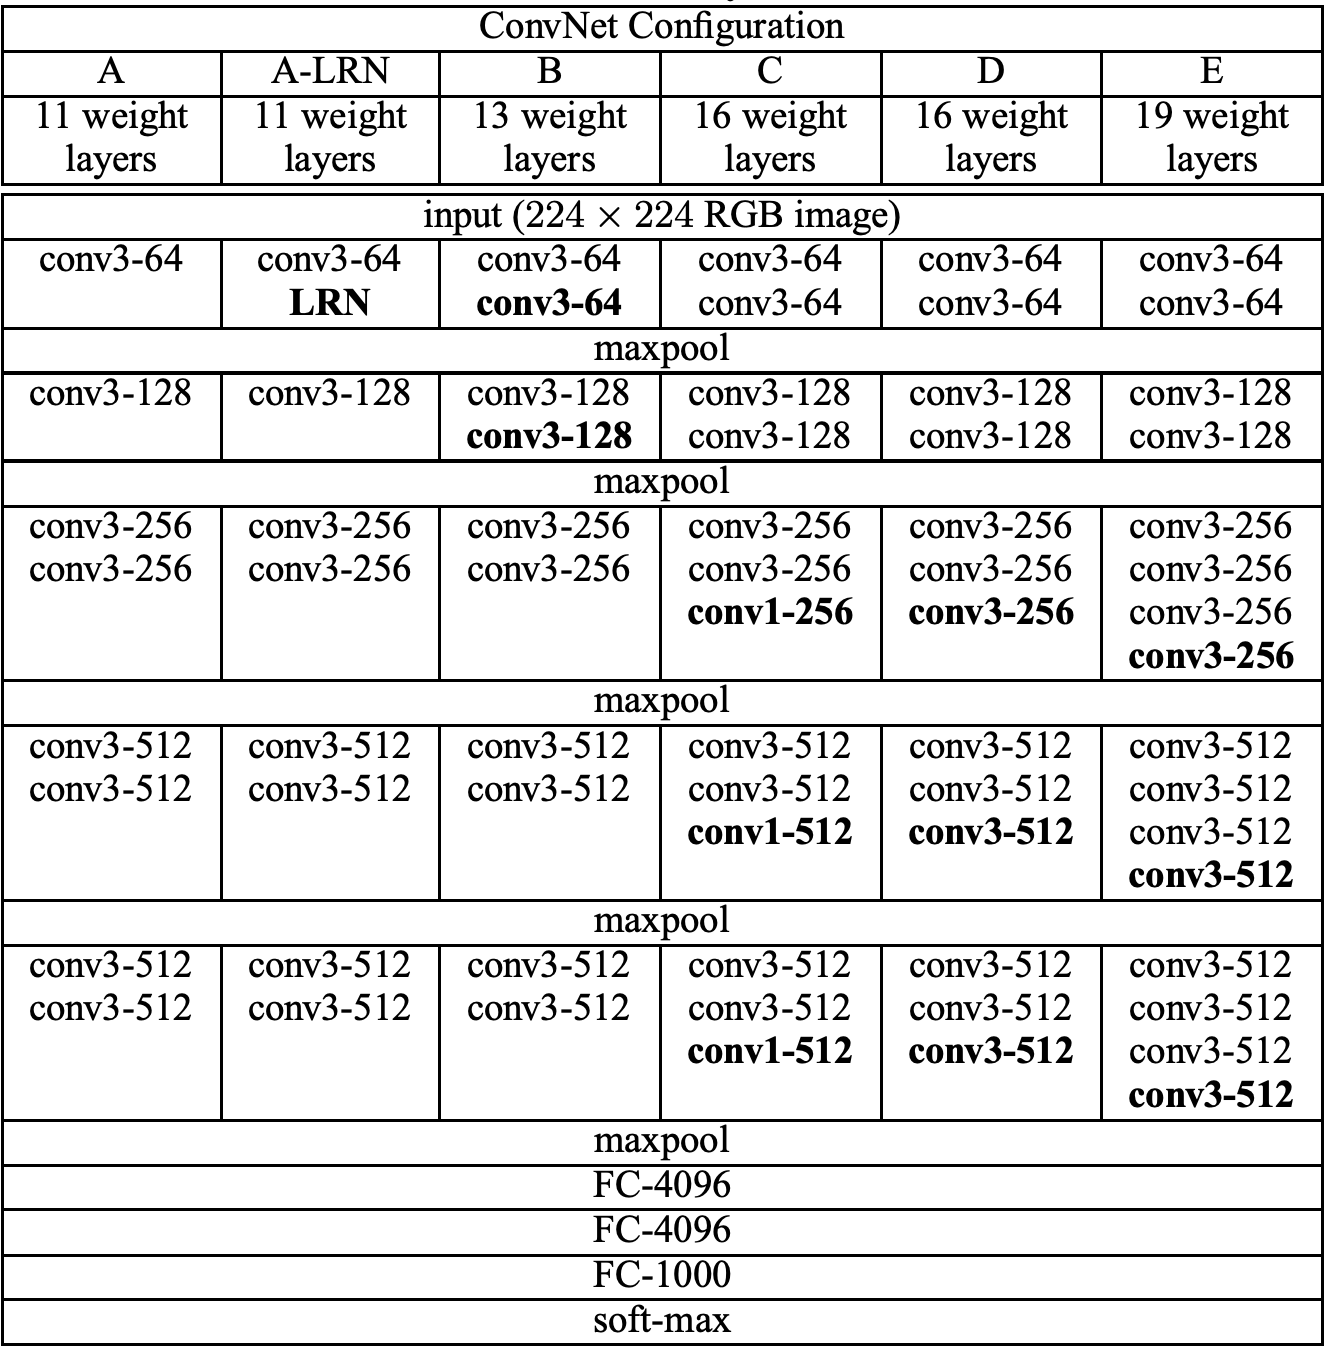

In [ ]:
!wget https://raw.githubusercontent.com/teavanist/MNIST-JPG/master/MNIST%20Dataset%20JPG%20format.zip

--2023-11-26 14:34:25--  https://raw.githubusercontent.com/teavanist/MNIST-JPG/master/MNIST%20Dataset%20JPG%20format.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52766564 (50M) [application/zip]
Saving to: ‘MNIST Dataset JPG format.zip’

MNIST Dataset JPG f 100%[===================>]  50.32M   228MB/s    in 0.2s    

2023-11-26 14:34:26 (228 MB/s) - ‘MNIST Dataset JPG format.zip’ saved [52766564/52766564]



In [ ]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 17.3 MB/s eta 0:00:00


In [ ]:
!unzip 'MNIST Dataset JPG format.zip'

Streaming output truncated to the last 5000 lines.
 extracting: MNIST Dataset JPG format/MNIST - JPG - training/9/18241.jpg  
 extracting: MNIST Dataset JPG format/MNIST - JPG - training/9/18251.jpg  
 extracting: MNIST Dataset JPG format/MNIST - JPG - training/9/1826.jpg  
 extracting: MNIST Dataset JPG format/MNIST - JPG - training/9/18277.jpg  
 extracting: MNIST Dataset JPG format/MNIST - JPG - training/9/18296.jpg  
 extracting: MNIST Dataset JPG format/MNIST - JPG - training/9/183.jpg  
 extracting: MNIST Dataset JPG format/MNIST - JPG - training/9/18350.jpg  
 extracting: MNIST Dataset JPG format/MNIST - JPG - training/9/18355.jpg  
 extracting: MNIST Dataset JPG format/MNIST - JPG - training/9/18374.jpg  
 extracting: MNIST Dataset JPG format/MNIST - JPG - training/9/18377.jpg  
 extracting: MNIST Dataset JPG format/MNIST - JPG - training/9/18382.jpg  
 extracting: MNIST Dataset JPG format/MNIST - JPG - training/9/18387.jpg  
 extracting: MNIST Dataset JPG format/MNIST - JPG - 

In [ ]:
!ls

'MNIST Dataset JPG format'  'MNIST Dataset JPG format.zip'   sample_data


In [ ]:
from glob import glob
import pandas as pd
import numpy as np
import os
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
import torchmetrics
import torch
from torch import nn
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
from lightning.pytorch.callbacks import ModelSummary

def set_seed(seed: int = 0) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")
set_seed()

Random seed set as 0


In [ ]:
val_path = "./MNIST Dataset JPG format/MNIST - JPG - testing/"
train_path = "./MNIST Dataset JPG format/MNIST - JPG - training/"
list_ = [name for name in os.listdir(train_path)]

In [ ]:
def get_path(path):
  paths = []
  for name in list_:
    l = glob(f"{path}{name}/*.jpg")
    for i in l:
      paths.append({"name": name,
                    "path": i,
                    "label": int(name)})
  return paths

train_paths = get_path(train_path)
val_paths = get_path(val_path)


In [ ]:
#_, train_paths = train_test_split(train_paths, test_size=0.4, random_state=43)
#_, val_paths = train_test_split(val_paths, test_size=0.4, random_state=43)

In [ ]:
class DataSet(torch.utils.data.Dataset):

  def __init__(self, features, transform=None):
    super(DataSet, self).__init__()
    self.features = features
    self.transform = transform

  def __len__(self):
    return len(self.features)

  def __getitem__(self, idx):
    paths = self.features[idx]["path"]
    images = torchvision.io.read_image(paths)
    images = torch.stack([images[0], images[0], images[0]], 0)

    if self.transform is not None:
        images = self.transform(images)

    label = torch.tensor(self.features[idx]["label"])
    return {"images": images, "labels": label}


Data = DataSet(train_paths)


In [ ]:
next(iter(Data))["images"].shape

torch.Size([3, 28, 28])

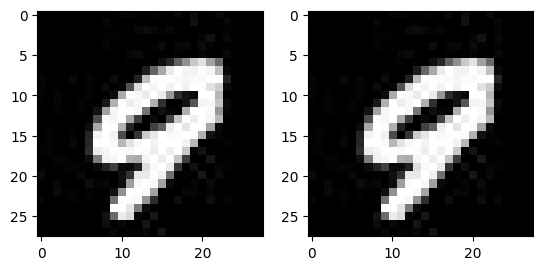

In [ ]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))

show([next(iter(Data))["images"], next(iter(Data))["images"]])

In [ ]:
class DataModule(L.LightningDataModule):
    def __init__(self, batch_size, num_workers, train_path, val_path):
        super(DataModule, self).__init__()
        self.train_path = train_path
        self.val_path = val_path
        self.batch_size = batch_size
        self.num_workers = num_workers
        # Tạo một danh sách các phép biến đổi bạn muốn áp dụng trong compose


# Tạo compose từ danh sách phép biến đổi
        self.train_transforms = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

            ]
        )

        self.test_transforms = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ]
        )

    def setup(self, stage=None):
        train_paths = get_path(self.train_path)
        val_paths = get_path(self.val_path)
        train_paths, test_paths = train_test_split(train_paths, test_size=0.2, random_state=0)

        self.train_dataset = DataSet(train_paths, transform=self.train_transforms)  # Áp dụng data_transforms trong DataSet
        self.val_dataset = DataSet(val_paths, transform=self.test_transforms)
        self.test_dataset = DataSet(test_paths, transform=self.test_transforms)


    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, shuffle=True,
                                           batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_dataset, shuffle=False,
                                           batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_dataset, shuffle=False,
                                           batch_size=self.batch_size, num_workers=self.num_workers)

data_module = DataModule(8, 2, train_path, val_path)
data_module.setup()
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()

In [ ]:
next(iter(train_loader))["images"].shape

torch.Size([8, 3, 224, 224])

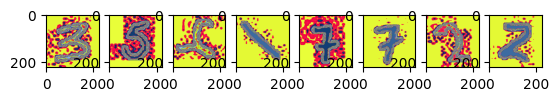

In [ ]:
images = [image for image in next(iter(train_loader))["images"]]
show(images)

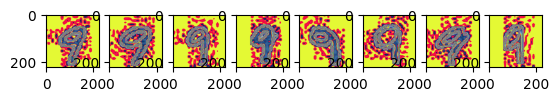

In [ ]:
images = [image for image in next(iter(val_loader))["images"]]
show(images)

# VGG-D

In [ ]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.features = self._make_layers()
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _make_layers(self):
        layers = []
        in_channels = 3
        vgg_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']

        for v in vgg_config:
            if v == 'M':
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v

        return nn.Sequential(*layers)


# Define a LightningModule using the custom VGG16
class CustomVGG16(L.LightningModule):
    def __init__(self, num_classes=10, lr=1e-4):
        super(CustomVGG16, self).__init__()
        self.model = VGG16(num_classes)
        self.lr = lr
        self.loss = torch.nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch['images'], batch['labels']
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'loss': loss, 'acc': accuracy}, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch['images'], batch['labels']
        y_hat = self(x)
        val_loss = self.loss(y_hat, y)
        val_accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'val_loss': val_loss, 'val_acc': val_accuracy}, prog_bar=True)
        return val_loss

    def test_step(self, batch, batch_idx):
        x, y = batch['images'], batch['labels']
        y_hat = self(x)
        test_loss = self.loss(y_hat, y)
        test_accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'test_loss': test_loss, 'test_acc': test_accuracy}, prog_bar=True)
        return test_loss

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        x, _ = batch['images'], batch['labels']
        y_hat = self(x)
        probabilities = torch.softmax(y_hat, dim=1)
        predicted_labels = torch.argmax(probabilities, dim=1)
        return {"y_pred": predicted_labels}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

In [ ]:
model_checkpoint = ModelCheckpoint(dirpath='checkpoint/',
                                   monitor="val_acc",
                                   verbose=True,
                                   mode="max",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_acc", mode="max", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping, ModelSummary(max_depth=1)]

model = CustomVGG16()

data_module = DataModule(128, 1, train_path, val_path)
trainer = L.Trainer(max_epochs=2, detect_anomaly=True, callbacks=callbacks)

trainer.fit(model, data_module)

INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
IN

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 375: 'val_acc' reached 0.82960 (best 0.82960), saving model to '/content/checkpoint/epoch=0-step=375.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 375: 'val_acc' reached 0.82960 (best 0.82960), saving model to '/content/checkpoint/epoch=0-step=375.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 750: 'val_acc' reached 0.97950 (best 0.97950), saving model to '/content/checkpoint/epoch=1-step=750.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 750: 'val_acc' reached 0.97950 (best 0.97950), saving model to '/content/checkpoint/epoch=1-step=750.ckpt' as top 1
INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


In [ ]:
trainer.test(model, data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9756666421890259     │
│         test_loss         │    0.07749564945697784    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.07749564945697784, 'test_acc': 0.9756666421890259}]

In [ ]:
data_module = DataModule(64, 8, train_path, val_path)
data_module.setup()
#train_loader = data_module.train_dataloader()
test_loader = data_module.test_dataloader()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
model = CustomVGG16.load_from_checkpoint("./checkpoint/epoch=1-step=750.ckpt")
predictions_ = trainer.predict(model, test_loader)
all_max_indices = torch.tensor([])
for i in predictions_:
    all_max_indices = torch.concat([all_max_indices, i['y_pred']])

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

# VGG-C



In [ ]:
class VGGC(nn.Module):
    def __init__(self, num_classes=10):
        super(VGGC, self).__init__()
        self.features = self._make_layers()
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _make_layers(self):
        layers = []
        in_channels = 3
        vgg_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']

        count = 0
        for v in vgg_config:

            if v == 'M':
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            else:
                # add conv1 layer at 8th, 12th, 16th layer
                if count == 8 or count == 12 or count == 16:
                    conv2d = nn.Conv2d(in_channels, v, kernel_size=1, padding=0)
                    layers += [conv2d, nn.ReLU(inplace=True)]
                else:
                    conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                    layers += [conv2d, nn.ReLU(inplace=True)]

                in_channels = v
            count += 1

        return nn.Sequential(*layers)


# Define a LightningModule using the custom VGGC
class CustomVGGC(L.LightningModule):
    def __init__(self, num_classes=10, lr=1e-4):
        super(CustomVGGC, self).__init__()
        self.model = VGGC(num_classes)
        self.lr = lr
        self.loss = torch.nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch['images'], batch['labels']
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'loss': loss, 'acc': accuracy}, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch['images'], batch['labels']
        y_hat = self(x)
        val_loss = self.loss(y_hat, y)
        val_accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'val_loss': val_loss, 'val_acc': val_accuracy}, prog_bar=True)
        return val_loss

    def test_step(self, batch, batch_idx):
        x, y = batch['images'], batch['labels']
        y_hat = self(x)
        test_loss = self.loss(y_hat, y)
        test_accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'test_loss': test_loss, 'test_acc': test_accuracy}, prog_bar=True)
        return test_loss

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        x, _ = batch['images'], batch['labels']
        y_hat = self(x)
        probabilities = torch.softmax(y_hat, dim=1)
        predicted_labels = torch.argmax(probabilities, dim=1)
        return {"y_pred": predicted_labels}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

In [ ]:
model_checkpoint = ModelCheckpoint(dirpath='checkpoint/',
                                   monitor="val_acc",
                                   verbose=True,
                                   mode="max",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_acc", mode="max", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping, ModelSummary(max_depth=1)]

model = CustomVGGC()

data_module = DataModule(128, 1, train_path, val_path)
trainer = L.Trainer(max_epochs=2, detect_anomaly=True, callbacks=callbacks)

trainer.fit(model, data_module)

INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
IN

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 375: 'val_acc' reached 0.95990 (best 0.95990), saving model to '/content/checkpoint/epoch=0-step=375.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 375: 'val_acc' reached 0.95990 (best 0.95990), saving model to '/content/checkpoint/epoch=0-step=375.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 750: 'val_acc' reached 0.97140 (best 0.97140), saving model to '/content/checkpoint/epoch=1-step=750-v1.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 750: 'val_acc' reached 0.97140 (best 0.97140), saving model to '/content/checkpoint/epoch=1-step=750-v1.ckpt' as top 1
INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


In [ ]:
trainer.test(model, data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9724166393280029     │
│         test_loss         │    0.08865606039762497    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.08865606039762497, 'test_acc': 0.9724166393280029}]

In [ ]:
data_module = DataModule(64, 8, train_path, val_path)
data_module.setup()
#train_loader = data_module.train_dataloader()
test_loader = data_module.test_dataloader()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
model = CustomVGGC.load_from_checkpoint("./checkpoint/epoch=1-step=750.ckpt")
predictions_ = trainer.predict(model, test_loader)
all_max_indices = torch.tensor([])
for i in predictions_:
    all_max_indices = torch.concat([all_max_indices, i['y_pred']])



INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

# VGG-E

In [ ]:
class VGGE(nn.Module):
    def __init__(self, num_classes=10):
        super(VGGE, self).__init__()
        self.features = self._make_layers()
        self.classifier = nn.Sequential(
            nn.Linear(512*7*7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _make_layers(self):
        layers = []
        in_channels = 3
        vgg_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']

        for v in vgg_config:
            if v == 'M':
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v

        return nn.Sequential(*layers)


# Define a LightningModule using the custom VGGE
class CustomVGGE(L.LightningModule):
    def __init__(self, num_classes=10, lr=1e-4):
        super(CustomVGGE, self).__init__()
        self.model = VGGE(num_classes)
        self.lr = lr
        self.loss = torch.nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch['images'], batch['labels']
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'loss': loss, 'acc': accuracy}, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch['images'], batch['labels']
        y_hat = self(x)
        val_loss = self.loss(y_hat, y)
        val_accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'val_loss': val_loss, 'val_acc': val_accuracy}, prog_bar=True)
        return val_loss

    def test_step(self, batch, batch_idx):
        x, y = batch['images'], batch['labels']
        y_hat = self(x)
        test_loss = self.loss(y_hat, y)
        test_accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'test_loss': test_loss, 'test_acc': test_accuracy}, prog_bar=True)
        return test_loss

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        x, _ = batch['images'], batch['labels']
        y_hat = self(x)
        probabilities = torch.softmax(y_hat, dim=1)
        predicted_labels = torch.argmax(probabilities, dim=1)
        return {"y_pred": predicted_labels}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

In [ ]:
model_checkpoint = ModelCheckpoint(dirpath='checkpoint/',
                                   monitor="val_acc",
                                   verbose=True,
                                   mode="max",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_acc", mode="max", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping, ModelSummary(max_depth=1)]

model = CustomVGGE()

data_module = DataModule(128, 1, train_path, val_path)
trainer = L.Trainer(max_epochs=2, detect_anomaly=True, callbacks=callbacks)

trainer.fit(model, data_module)

INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
IN

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 375: 'val_acc' reached 0.95110 (best 0.95110), saving model to '/content/checkpoint/epoch=0-step=375.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 375: 'val_acc' reached 0.95110 (best 0.95110), saving model to '/content/checkpoint/epoch=0-step=375.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 750: 'val_acc' reached 0.97630 (best 0.97630), saving model to '/content/checkpoint/epoch=1-step=750.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 750: 'val_acc' reached 0.97630 (best 0.97630), saving model to '/content/checkpoint/epoch=1-step=750.ckpt' as top 1
INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


In [ ]:
trainer.test(model, data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9765833616256714     │
│         test_loss         │    0.07883606106042862    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.07883606106042862, 'test_acc': 0.9765833616256714}]

In [ ]:
data_module = DataModule(64, 8, train_path, val_path)
data_module.setup()
#train_loader = data_module.train_dataloader()
test_loader = data_module.test_dataloader()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
model = CustomVGGE.load_from_checkpoint("./checkpoint/epoch=1-step=750.ckpt")
predictions_ = trainer.predict(model, test_loader)
all_max_indices = torch.tensor([])
for i in predictions_:
    all_max_indices = torch.concat([all_max_indices, i['y_pred']])



INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]